In [1]:
#The basics
import pandas as pd
import numpy as np
import json

#Plotting
import matplotlib.pyplot as plt
import FCPython 

#Statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf

#Decide which league to load
#Wyscout data from https://figshare.com/collections/Soccer_match_event_dataset/4415000/2
with open('Wyscout/events/events_England.json') as f:
    data = json.load(f)
    
#Create a data set of shots.
train = pd.DataFrame(data)
pd.unique(train['subEventName'])
shots=train[train['subEventName']=='Shot']
shots_model=pd.DataFrame(columns=['Goal','X','Y'])

#Go through the dataframe and calculate X, Y co-ordinates.
#Distance from a line in the centre
#Shot angle.
#Details of tags can be found here: https://apidocs.wyscout.com/matches-wyid-events
for i,shot in shots.iterrows():
    
    header=0
    for shottags in shot['tags']:
        if shottags['id']==403:
            header=1
    #Only include non-headers        
    if not(header):        
        shots_model.at[i,'X']=100-shot['positions'][0]['x']
        shots_model.at[i,'Y']=shot['positions'][0]['y']
        shots_model.at[i,'C']=abs(shot['positions'][0]['y']-50)
    
        #Distance in metres and shot angle in radians.
        x=shots_model.at[i,'X']*105/100
        y=shots_model.at[i,'C']*65/100
        shots_model.at[i,'Distance']=np.sqrt(x**2 + y**2)
        a = np.arctan(7.32 *x /(x**2 + y**2 - (7.32/2)**2))
        if a<0:
            a=np.pi+a
        shots_model.at[i,'Angle'] =a
    
        #Was it a goal
        shots_model.at[i,'Goal']=0
        for shottags in shot['tags']:
                #Tags contain that its a goal
                if shottags['id']==101:
                    shots_model.at[i,'Goal']=1

#Two dimensional histogram
H_Shot=np.histogram2d(shots_model['X'], shots_model['Y'],bins=50,range=[[0, 100],[0, 100]])
goals_only=shots_model[shots_model['Goal']==1]
H_Goal=np.histogram2d(goals_only['X'], goals_only['Y'],bins=50,range=[[0, 100],[0, 100]])

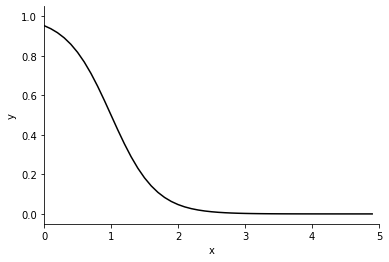

In [12]:
#Plot a logistic curve
b=[3, -3]
x=np.arange(5,step=0.1)
y=1/(1+np.exp(-b[0]-b[1]*x))
fig,ax=plt.subplots(num=1)
plt.ylim((-0.05,1.05))
plt.xlim((0,5))
ax.set_ylabel('y')
ax.set_xlabel("x") 
ax.plot(x, y, linestyle='solid', color='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

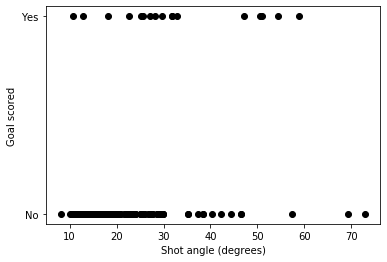

In [13]:
#Get first 200 shots
shots_200=shots_model.iloc[:200]

#Plot first 200 shots goal angle
fig,ax=plt.subplots(num=1)
ax.plot(shots_200['Angle']*180/np.pi, shots_200['Goal'], linestyle='none', marker= '.', markerSize= 12, color='black')
ax.set_ylabel('Goal scored')
ax.set_xlabel("Shot angle (degrees)")
plt.ylim((-0.05,1.05))
ax.set_yticks([0,1])
ax.set_yticklabels(['No','Yes'])
plt.show()

C:\Users\ducnm\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


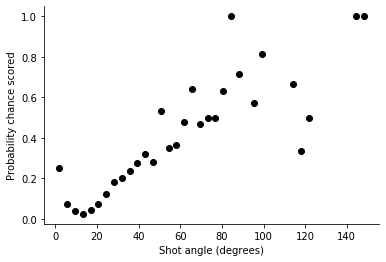

In [4]:
#Show empirically how goal angle predicts probability of scoring
shotcount_dist=np.histogram(shots_model['Angle']*180/np.pi,bins=40,range=[0, 150])
goalcount_dist=np.histogram(goals_only['Angle']*180/np.pi,bins=40,range=[0, 150])
prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])
angle=shotcount_dist[1]
midangle= (angle[:-1] + angle[1:])/2
fig,ax=plt.subplots(num=2)
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markerSize= 12, color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Shot angle (degrees)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [14]:
# Code commented out here, because only for illustrative purposes.
#Try some models by hand
#First try a linear model
#This is NOT a good model because a probability can't be less than zero or more than one
#Intercept and Slope
#b=[-0.05, 1/125]
#x=np.arange(150,step=0.1)
#y= b[0] + b[1]*x 
#ax.plot(x, y, linestyle='solid', color='black')

#Now try sigmoid model
#This is a good model but NOT a good way of fitting.
#because each point contains lots of data points
b=[3, -3]
x=np.arange(150,step=0.1)
y=1/(1+np.exp(b[0]+b[1]*x*np.pi/180)) 
ax.plot(x, y, linestyle='solid', color='black')
plt.show()

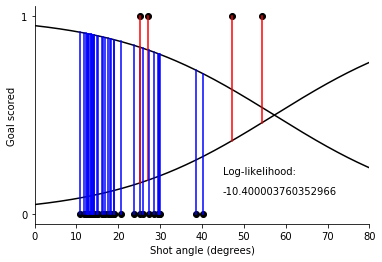

In [7]:
#Now lets look at the likelihood of model given data
xG=1/(1+np.exp(b[0]+b[1]*shots_model['Angle'])) 
shots_model = shots_model.assign(xG=xG)
shots_40=shots_model.iloc[:40]
fig,ax=plt.subplots(num=1)
ax.plot(shots_40['Angle']*180/np.pi, shots_40['Goal'], linestyle='none', marker= '.', markerSize= 12, color='black')
ax.plot(x, y, linestyle='solid', color='black')
ax.plot(x, 1-y, linestyle='solid', color='black')
loglikelihood=0
for item,shot in shots_40.iterrows():
    ang=shot['Angle']*180/np.pi
    if shot['Goal']==1:
        loglikelihood=loglikelihood+np.log(shot['xG'])
        ax.plot([ang,ang],[shot['Goal'],shot['xG']], color='red')
    else:
        loglikelihood=loglikelihood+np.log(1 - shot['xG'])
        ax.plot([ang,ang],[shot['Goal'],1-shot['xG']], color='blue')
    
ax.set_ylabel('Goal scored')
ax.set_xlabel("Shot angle (degrees)")
plt.ylim((-0.05,1.05))
plt.xlim((0,80))
plt.text(45,0.2,'Log-likelihood:') 
plt.text(45,0.1,str(loglikelihood))
ax.set_yticks([0,1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# fig.savefig('Output/LikelihoodExample.pdf', dpi=None, bbox_inches="tight")   
plt.show()

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 7134
Model:                                GLM   Df Residuals:                     7132
Model Family:                    Binomial   Df Model:                            1
Link Function:                      logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -2056.3
Date:                    Tue, 07 Jul 2020   Deviance:                       4112.7
Time:                            13:11:02   Pearson chi2:                 6.70e+03
No. Iterations:                         6                                         
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

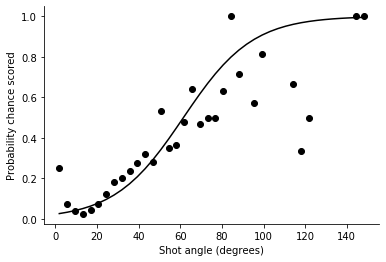

In [8]:
#Make single variable model of angle
#Using logistic regression we find the optimal values of b
#This process minimizes the loglikelihood
test_model = smf.glm(formula="Goal ~ Angle" , data=shots_model, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params


xGprob=1/(1+np.exp(b[0]+b[1]*midangle*np.pi/180)) 
fig,ax=plt.subplots(num=1)
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markerSize= 12, color='black')
ax.plot(midangle, xGprob, linestyle='solid', color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Shot angle (degrees)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()
# fig.savefig('Output/ProbabilityOfScoringAngleFit.pdf', dpi=None, bbox_inches="tight")   

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 7134
Model:                                GLM   Df Residuals:                     7132
Model Family:                    Binomial   Df Model:                            1
Link Function:                      logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -2010.7
Date:                    Tue, 07 Jul 2020   Deviance:                       4021.3
Time:                            13:11:22   Pearson chi2:                 1.90e+04
No. Iterations:                         6                                         
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

C:\Users\ducnm\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


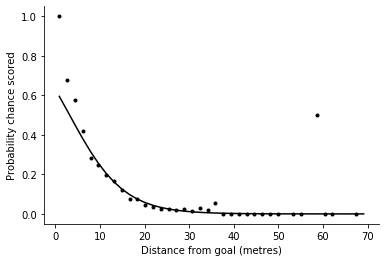

In [9]:



#Now lets look at distance from goal


#Show empirically how distance from goal predicts probability of scoring
shotcount_dist=np.histogram(shots_model['Distance'],bins=40,range=[0, 70])
goalcount_dist=np.histogram(goals_only['Distance'],bins=40,range=[0, 70])
prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])
distance=shotcount_dist[1]
middistance= (distance[:-1] + distance[1:])/2
fig,ax=plt.subplots(num=1)
ax.plot(middistance, prob_goal, linestyle='none', marker= '.', color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Distance from goal (metres)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


#Make single variable model of distance
test_model = smf.glm(formula="Goal ~ Distance" , data=shots_model, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params
xGprob=1/(1+np.exp(b[0]+b[1]*middistance)) 
ax.plot(middistance, xGprob, linestyle='solid', color='black')
plt.show()
# fig.savefig('Output/ProbabilityOfScoringDistance.pdf', dpi=None, bbox_inches="tight")   

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 7134
Model:                                GLM   Df Residuals:                     7131
Model Family:                    Binomial   Df Model:                            2
Link Function:                      logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -1992.2
Date:                    Tue, 07 Jul 2020   Deviance:                       3984.3
Time:                            14:03:05   Pearson chi2:                 7.12e+03
No. Iterations:                         7                                         
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

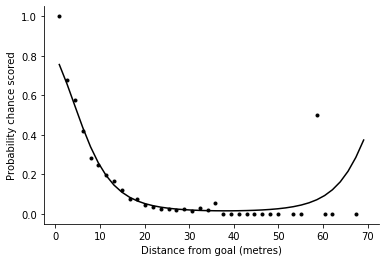

In [10]:


#Adding distance squared
squaredD = shots_model['Distance']**2
shots_model = shots_model.assign(D2=squaredD)
test_model = smf.glm(formula="Goal ~ Distance + D2" , data=shots_model, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params
xGprob=1/(1+np.exp(b[0]+b[1]*middistance+b[2]*pow(middistance,2))) 
fig,ax=plt.subplots(num=1)
ax.plot(middistance, prob_goal, linestyle='none', marker= '.', color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Distance from goal (metres)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.plot(middistance, xGprob, linestyle='solid', color='black')
plt.show()
# fig.savefig('Output/ProbabilityOfScoringDistanceSquared.pdf', dpi=None, bbox_inches="tight")   

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 7134
Model:                                GLM   Df Residuals:                     7129
Model Family:                    Binomial   Df Model:                            4
Link Function:                      logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -1988.0
Date:                    Tue, 07 Jul 2020   Deviance:                       3976.0
Time:                            14:03:25   Pearson chi2:                 9.33e+03
No. Iterations:                         7                                         
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

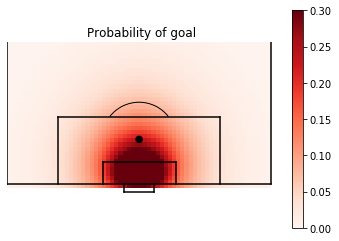

In [11]:
#Adding even more variables to the model.
squaredX = shots_model['X']**2
shots_model = shots_model.assign(X2=squaredX)
squaredC = shots_model['C']**2
shots_model = shots_model.assign(C2=squaredC)
AX = shots_model['Angle']*shots_model['X']
shots_model = shots_model.assign(AX=AX)


# A general model for fitting goal probability
# List the model variables you want here
model_variables = ['Angle','Distance','X','C']
model=''
for v in model_variables[:-1]:
    model = model  + v + ' + '
model = model + model_variables[-1]


#Fit the model
test_model = smf.glm(formula="Goal ~ " + model, data=shots_model, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params


#Return xG value for more general model
def calculate_xG(sh):    
   bsum=b[0]
   for i,v in enumerate(model_variables):
       bsum=bsum+b[i+1]*sh[v]
   xG = 1/(1+np.exp(bsum)) 
   return xG   

#Add an xG to my dataframe
xG=shots_model.apply(calculate_xG, axis=1) 
shots_model = shots_model.assign(xG=xG)


#Create a 2D map of xG
pgoal_2d=np.zeros((65,65))
for x in range(65):
    for y in range(65):
        sh=dict()
        a = np.arctan(7.32 *x /(x**2 + abs(y-65/2)**2 - (7.32/2)**2))
        if a<0:
            a = np.pi + a
        sh['Angle'] = a
        sh['Distance'] = np.sqrt(x**2 + abs(y-65/2)**2)
        sh['D2'] = x**2 + abs(y-65/2)**2
        sh['X'] = x
        sh['AX'] = x*a
        sh['X2'] = x**2
        sh['C'] = abs(y-65/2)
        sh['C2'] = (y-65/2)**2
        
        pgoal_2d[x,y] =  calculate_xG(sh)

(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(pgoal_2d, extent=[-1,65,65,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.3)
fig.colorbar(pos, ax=ax)
ax.set_title('Probability of goal')
plt.xlim((0,66))
plt.ylim((-3,35))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
# fig.savefig('Output/goalprobfor_' + model  + '.pdf', dpi=None, bbox_inches="tight")   

In [42]:
from sklearn.linear_model import LogisticRegression

columns = shots_model.columns
print(columns.values)
train_data = shots_model.iloc[:,[1,2,4,5,7,8,9,10]].values
y = shots_model["Goal"].astype('int').values
clf = LogisticRegression(random_state=0).fit(train_data,y)
clf.predict_proba(train_data)

['Goal' 'X' 'Y' 'C' 'Distance' 'Angle' 'xG' 'D2' 'X2' 'C2' 'AX']


C:\Users\ducnm\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


array([[0.86155572, 0.13844428],
       [0.88529631, 0.11470369],
       [0.96193291, 0.03806709],
       ...,
       [0.93805427, 0.06194573],
       [0.89021255, 0.10978745],
       [0.83026139, 0.16973861]])

In [44]:
clf.score(train_data,y)

0.9010372862349313

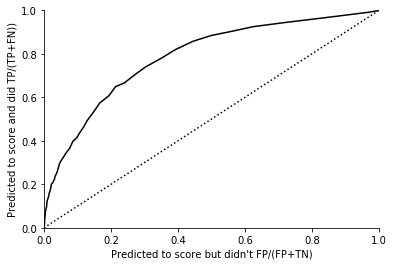

In [45]:
#Mcfaddens Rsquared for Logistic regression
null_model = smf.glm(formula="Goal ~ 1 ", data=shots_model, 
                           family=sm.families.Binomial()).fit()
1-test_model.llf/null_model.llf

#ROC curve
numobs=100
TP=np.zeros(numobs)
FP=np.zeros(numobs)
TN=np.zeros(numobs)
FN=np.zeros(numobs)


for i,threshold in enumerate(np.arange(0,1,1/numobs)):
    for j,shot in shots_model.iterrows():
        if (shot['Goal']==1): 
            if(shot['xG']>threshold):
                TP[i] = TP[i] + 1
            else:
                FN[i] = FN[i] + 1
        if (shot['Goal']==0): 
            if(shot['xG']>threshold):
                FP[i] = FP[i] + 1
            else:
                TN[i] = TN[i] + 1
     

fig,ax=plt.subplots(num=1)
ax.plot(FP/(FP+TN), TP/(TP+FN), color='black')
ax.plot([0,1], [0,1], linestyle='dotted', color='black')
ax.set_ylabel("Predicted to score and did TP/(TP+FN))")
ax.set_xlabel("Predicted to score but didn't FP/(FP+TN)")
plt.ylim((0.00,1.00))
plt.xlim((0.00,1.00))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)           
# fig.savefig('Output/ROC_' + model  + '.pdf', dpi=None, bbox_inches="tight")   